In [1]:
!scp ghpcc:/nl/umw_job_dekker/users/av90w/distiller-run/20211104_Haarthuis_WAPL/results/coolers_library/*mapq_30.1000.mcool ./

Haarthuis-HAP1-WT.hg19.mapq_30.1000.mcool     100% 1972MB  15.3MB/s   02:08    
Haarthuis-WAPL-KO1.14.hg19.mapq_30.1000.mcool 100% 1599MB  16.9MB/s   01:34    
Haarthuis-WAPL-KO3.3.hg19.mapq_30.1000.mcool  100% 1682MB  18.0MB/s   01:33    


In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

In [4]:
# !scp ghpcc:/nl/umw_job_dekker/users/av90w/projects/for-paper/fig2/G4-CTCF-dots/intersect-all-NT-CTCF-NO-G4-centered-RAD21 ./

In [5]:
ctcf_df = bioframe.read_table(
    "intersect-all-NT-CTCF-NO-G4-centered-RAD21",
    names=["chrom","start","end"],
    usecols=[0,1,2]
)
ctcf_df = ctcf_df.sort_values(["chrom","start"])
ctcf_df = ctcf_df[ ctcf_df["chrom"].isin(autosomal_chroms) ]
ctcf_df["type"] = "ctcf"
ctcf_df = ctcf_df.reset_index(drop=True)

#### Annotate our CTCF ChipSeq peaks with the motifs ...

Actually - we have do it after the fact !
i.e. we first treat CTCF as a peak, look for intersections of whatever
select those that fit our inderstanding and only then
we try to annotate them with motifs, and keep only those interactions (selection)
where we could annotate them with the motif

Why ?
because otherwise , as we narrow the possible number of CTCF to peaks from,
some criteria that rely on CTCF being isolated, or that we look at pairs of CTCF
that have nothing between them .. - these criteria would "fail" because we would skip
some of the CTCFs ...

OR - even better !
annotate CTCFs with the motif orientation, keeping undetermined ones as `orientation=None`

In [6]:
### CTCF motif: http://jaspar.genereg.net/matrix/MA0139.1/
jaspar_url = 'http://expdata.cmmt.ubc.ca/JASPAR/downloads/UCSC_tracks/2022/hg19/'
jaspar_motif_file = 'MA0139.1.tsv.gz'
ctcf_motifs = bioframe.read_table(
                jaspar_url+jaspar_motif_file,
                skiprows=1,
                names=["chrom", "start", "end","name","score", "pval", "strand"]
)
ctcf_motifs = ctcf_motifs.sort_values(["chrom","start"])
ctcf_motifs = ctcf_motifs[ ctcf_motifs["chrom"].isin(autosomal_chroms) ]
ctcf_motifs = ctcf_motifs.reset_index(drop=True)

# beforehand we used FIMO to find motifs in the hg19 - ourselves
# it seems to match the published one - OK - so we'll use the published one:
# # here is very-very liberal list of CTCF calls in hg19, based on "MA0139.1.meme" from JASPAR
# # P-val cutoff was 1e-4 - let's see how it looks here ...
# !scp ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/CTCF_motif/CTCF.hist.txt ./CTCF.MA0139.1.txt

In [9]:
ctcf_motif_annotated = bioframe.overlap(
    ctcf_df,
    ctcf_motifs,
    how="left",
    suffixes=('','_')
)

# for a peak with several motifs, assign the "strongest" one:
# NOTE pval here is actually -1 * log10(actual_pval) * 100 , i.e. 10^(-13) --> 1_300
max_idx = ctcf_motif_annotated.dropna(subset=["pval_"]).groupby(["chrom","start","end"])["pval_"].idxmax().to_numpy()

# get indices of the peaks without motifs
na_idx, = ctcf_motif_annotated["pval_"].isnull().to_numpy().nonzero()

# better numpy merge sorted: https://stackoverflow.com/questions/27916710/numpy-merge-sorted-array-to-an-new-array
sorted_idx = np.concatenate([max_idx, na_idx])
sorted_idx = np.sort(sorted_idx)

_cols = ["chrom",
        "start",
        "end",
        "type",
        "strand_"]
_rename_cols = {"strand_":"strand"}

# now select annotated and not-annotated CTCF peaks
ctcf_motif_annotated = ctcf_motif_annotated \
                        .loc[sorted_idx,_cols] \
                        .rename(_rename_cols,axis=1) \
                        .reset_index(drop=True)

print(f"there are { ctcf_motif_annotated['strand'].isnull().sum() } CTCF-CHipSeq-peaks-with-RAD21 that do not have a MOTIF associated with them out of {len(ctcf_df)}")
print("we're keeping them in the table with the strand=None")

there are 717 CTCF-CHipSeq-peaks-with-RAD21 that do not have a MOTIF associated with them out of 9347
we're keeping them in the table with the strand=None


#### read a list of active TSSs ...

In [10]:
# this is how one can read a DataFrame into memory:
# bf is short for bioframe here ...
feature_of_interest = "ActiveTSS-NO-CTCF-8849-1bp.bed"
tss_df = bioframe.read_table(
    feature_of_interest,
    names=["chrom","start","end","strand"]
)
tss_df = tss_df.sort_values(["chrom","start"]) # sort ...
tss_df = tss_df[tss_df["chrom"].isin(autosomal_chroms)] # filter chroms
tss_df["type"] = "tss"
tss_df = tss_df.reset_index(drop=True)

```python
# just an example-prototype on how we can do pairwise combinations dissected by orientation/type/etc
# also in this case we are combining 2 lists of intervals - to get to pairwise interactions between the two
# let's assume that we have 2 dataframes - df and df1 :
a = df.head().copy()
b = df1.head().copy()
a["type"] = "a"
b["type"] = "b"

xxx = pd.concat([a,b]).reset_index(drop=True)
print(xxx)

yyy = bioframe.pair_by_distance(xxx,min_sep=0,max_sep=100000000)
# select only interactions between different types ...
print(yyy[yyy["type_1"] != yyy["type_2"]].reset_index(drop=True))
```

### For every active TSS, try to find CTCF nearest CTCF upstream and downstream, then select those in a convergent orientation

In [19]:
bioframe.closest?

In [25]:
_up = bioframe.closest(
    tss_df,
    ctcf_motif_annotated,
    k=1,
    ignore_overlaps=True,
    ignore_upstream=False,
    ignore_downstream=True,
    suffixes=('1', '2'),
)

_down = bioframe.closest(
    tss_df,
    ctcf_motif_annotated,
    k=1,
    ignore_overlaps=True,
    ignore_upstream=True,
    ignore_downstream=False,
    suffixes=('1', '2'),
)

# we also have to make sure that in this ctcf/TSS intervals there are no
# other TSSs, i think - there shouldn't be

In [74]:
# "calculate" active TSSs, surrounded by CTCFs on both sides ...
tss_surround = pd.merge(_up, _down, how="outer", on=["chrom1","start1","end1","strand1","type1"],suffixes=["_down","_up"])
tss_surround = tss_surround.rename({"chrom2_down":"chrom_down",
                                    "start2_down":"start_down",
                                    "end2_down":"end_down",
                                    "type2_down":"type_down",
                                    "strand2_down":"strand_down",
                                    "distance_down":"distanc_down",
                                    "chrom2_up":"chrom_up",
                                    "start2_up":"start_up",
                                    "end2_up":"end_up",
                                    "type2_up":"type_up",
                                    "strand2_up":"strand_up",
                                    "distance_up":"distanc_up"},axis=1)
tss_surround = tss_surround.groupby(["chrom_down","start_down","end_down","strand_down","chrom_up","start_up","end_up","strand_up"]).size()
tss_surround.name = "number_tss"
tss_surround = tss_surround.reset_index()
tss_surround["size"] = tss_surround["start_up"] - tss_surround["start_down"]

In [89]:
tss_surround[tss_surround["number_tss"]>=1] \
    .groupby(["strand_down","strand_up"]) \
    .get_group(("+","-")) \
    .to_csv("convergent_ctcf_around_severalTSS.tsv",sep="\t")

tss_surround[tss_surround["number_tss"]>=1] \
    .groupby(["strand_down","strand_up"]) \
    .get_group(("+","+")) \
    .to_csv("ctcf++_around_severalTSS.tsv",sep="\t")

tss_surround[tss_surround["number_tss"]>=1] \
    .groupby(["strand_down","strand_up"]) \
    .get_group(("-","-")) \
    .to_csv("ctcf--_around_severalTSS.tsv",sep="\t")

tss_surround[tss_surround["number_tss"]>=1] \
    .groupby(["strand_down","strand_up"]) \
    .get_group(("-","+")) \
    .to_csv("ctcf-+_around_severalTSS.tsv",sep="\t")

In [90]:
!ls ctcf*around*

ctcf++_around_severalTSS.tsv  ctcf--_around_severalTSS.tsv
ctcf-+_around_severalTSS.tsv


In [91]:
!scp ctcf*around* ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

ctcf++_around_severalTSS.tsv                  100%   49KB 554.8KB/s   00:00    
ctcf-+_around_severalTSS.tsv                  100%   53KB 530.9KB/s   00:00    
ctcf--_around_severalTSS.tsv                  100%   46KB 579.2KB/s   00:00    


In [87]:
!ssh ghpcc ls /nl/umw_job_dekker/users/sv49w/ALV2021

ActiveTSS-13412-1bp.bed
ActiveTSS-13812-1bp_HCT116.bed
ActiveTSS_HAP1-CTCFsorted-November.pdf
ActiveTSS-NO-CTCF-6802-1bp_HCT116_HAP1.bed
ActiveTSS-NO-CTCF-8504-1bp_HCT116.bed
ActiveTSS-NO-CTCF-8849-1bp.bed
ActiveTTS-withoutH3K4-1bp.bed
ActiveTTS-withoutH3K4-NO-CTCF-10933-1bp.bed
activeTTS_wstrand.bed
allTSS_wstrand.bed
allTTS_wstrand.bed
chip_fastq.md5
chip_fastq.tsv
chipf.err
chipf.out
chipfup.err
chipfup.out
chipp.err
chipp.out
chip_processed.md5
chip_processed.tsv
chippup.err
chippup.out
CTCF_motif
CTCF_narrowPeak_HCT116_ENCODE.bed
ddx55-rad21.pdf
ddx55-rad21-rep2.pdf
EP_50-500kb_with_CTCF_status.bedpe
fastq.err
fastq.out
Fig1_masterlist_all.pdf
Fig2_ctcf_g4.pdf
Fig2_ctcf.pdf
Fig2_g4.pdf
Fig2-Jul1.pdf
Fig2-May26.pdf
Fig2.pdf
Fig3A-Rloops-TTS.pdf
Fig3B-Rloops-TTS.pdf
Fig3C.pdf
Fig3C_withPolII.pdf
Fig3-Rloops-TTS.pdf
Fig4-ctcf.pdf
Fig4-ddf-taf.pdf
Fig5D-ddx-taf.pdf
Fig5E-DDX-TAF-signal-quantification.pdf
Fig5E-DDX-TAF-signal-quantification.svg
Fig5-Rloops-STRONG-TSS-TTS.pdf
Fig5-Rloop

In [79]:
tss_surround[tss_surround["number_tss"]==1].groupby(["strand_down","strand_up"]).get_group(("+","-")).to_csv("convergent_ctcf_around_singleTSS.tsv",sep="\t")

In [82]:
!ls convergent_ctcf_around*

convergent_ctcf_around_severalTSS.tsv  convergent_ctcf_around_singleTSS.tsv


<AxesSubplot:>

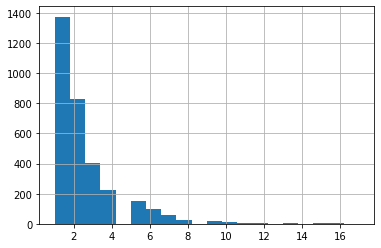

In [63]:
sss["number_tss"].hist(bins=20)

### Try to deal with the neighbours analysis ...

#### strategy to address the neighbours ...

1. for every CTCF (+/-) check "closest" TSS (+/-):
     - first "upstream" - independently
     - second "downstream" - indep.
     - Note that this way >1 CTCF can "interact" with the same TSS
2. For both of these lists - groupby TSS and pick nearest CTCF in a per TSS manner
     - This way we ensure there is nothing between a given TSS and CTCF
     - for a given TSS we also keep track of 2 closest CTCFs up- and down-stream
3. Concatenate resulting two lists _up_ and _down_ -> this is the final list of CTCF-TSS interactions

In [139]:
# for every CTCF find nearest TSS downstream
_down = bioframe.closest(
    ctcf_motif_annotated,
    tss_df,
    k=1,
    ignore_overlaps=True,
    ignore_upstream=True,
    ignore_downstream=False,
    suffixes=('1', '2'),
)
# groupby on TSSs - to select the closest CTCF
# and make sure we get CTCF-TSS interactions with nothing in between
# display(_down)
_down_tss = _down.loc[_down.groupby(["chrom2","start2","end2"])["distance"].idxmin()]
display(_down_tss)
(_down_tss["start2"]>_down_tss["end1"]).all()

,chrom1,start1,end1,type1,strand1,chrom2,start2,end2,strand2,type2,distance
0,chr1,10151,10508,ctcf,-,chr1,29369,29370,-,tss,18861
1,chr1,804937,805691,ctcf,+,chr1,894635,894636,-,tss,88944
2,chr1,919017,919979,ctcf,+,chr1,1004716,1004717,-,tss,84737
3,chr1,1057249,1057885,ctcf,+,chr1,1167380,1167381,-,tss,109495
6,chr1,1891306,1891906,ctcf,+,chr1,1935224,1935225,-,tss,43318
...,...,...,...,...,...,...,...,...,...,...,...
8605,chr9,139622478,139623139,ctcf,-,chr9,139702399,139702400,+,tss,79260
8607,chr9,139943613,139944735,ctcf,+,chr9,139948512,139948513,-,tss,3777
8608,chr9,140015675,140016394,ctcf,+,chr9,140095192,140095193,-,tss,78798
8609,chr9,140188936,140190350,ctcf,+,chr9,140335808,140335809,-,tss,145458


True

In [141]:
# for every CTCF find nearest TSS downstream
_up = bioframe.closest(
    ctcf_motif_annotated,
    tss_df,
    k=1,
    ignore_overlaps=True,
    ignore_upstream=False,
    ignore_downstream=True,
    suffixes=('1', '2'),
)
# groupby on TSSs - to select the closest CTCF
# and make sure we get CTCF-TSS interactions with nothing in between
# display(_up)
_up_tss = _up.loc[_up.groupby(["chrom2","start2","end2"])["distance"].idxmin()]
display(_up_tss)
(_up_tss["start2"]<_up_tss["end1"]).all()

,chrom1,start1,end1,type1,strand1,chrom2,start2,end2,strand2,type2,distance
0,chr1,804937,805691,ctcf,+,chr1,762970,762971,+,tss,41966
1,chr1,919017,919979,ctcf,+,chr1,901861,901862,+,tss,17155
2,chr1,1057249,1057885,ctcf,+,chr1,1051468,1051469,-,tss,5780
3,chr1,1875287,1875966,ctcf,+,chr1,1822618,1822619,+,tss,52668
6,chr1,1976044,1976838,ctcf,-,chr1,1935224,1935225,-,tss,40819
...,...,...,...,...,...,...,...,...,...,...,...
8606,chr9,139929536,139930441,ctcf,+,chr9,139886873,139886874,+,tss,42662
8608,chr9,140015675,140016394,ctcf,+,chr9,140009184,140009185,-,tss,6490
8609,chr9,140188936,140190350,ctcf,+,chr9,140149778,140149779,+,tss,39157
8610,chr9,140339533,140340365,ctcf,-,chr9,140335808,140335809,-,tss,3724


True

there should be 0 duplicated interactions in our list - we got 0
there are 1499 TSS that show up >1 in the interactions list (they have >1 nearest CTCF)
there are 1567 CTCF that show up >1 in the interactions list
there are 5677 TSS we have in the interaction list, out of 8849 total (3172 unused ...)
there are 0 super short range CTCF-TSS interactions in our final list


<AxesSubplot:ylabel='Frequency'>

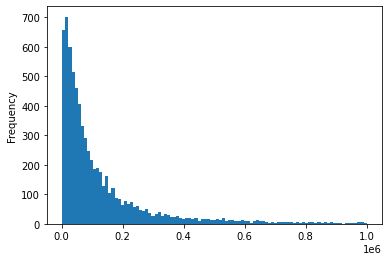

In [131]:
#####
# Concatenating up and down CTCF-TSS as is ! without flipping - just to produce some
# important informational messages ...
# to be redone for output and other checks ...
#####
# concat upp and down CTCF-TSS interactions:
_ctcf_tss_df = pd.concat([_up_tss,_down_tss]).reset_index(drop=True)
# are there any duplicated interactions for whatever reason - should be none ...
dups_ints = _ctcf_tss_df.duplicated(subset=["chrom1","start1","end1","chrom2","start2","end2"]).sum()
print(f"there should be 0 duplicated interactions in our list - we got {dups_ints}")
# how many TSS show up twice in the list ?
dups_tss = _ctcf_tss_df.duplicated(subset=["chrom2","start2","end2"]).sum()
print(f"there are {dups_tss} TSS that show up >1 in the interactions list (they have >1 nearest CTCF)")
# how many CTCF show up twice in the list ?
dups_ctcf = _ctcf_tss_df.duplicated(subset=["chrom1","start1","end1"]).sum()
print(f"there are {dups_ctcf} CTCF that show up >1 in the interactions list")
# how many unique TSS are we dealing with ?
uniq_tss = len(_ctcf_tss_df.drop_duplicates(subset=["chrom2","start2","end2"]))
print(f"there are {uniq_tss} TSS we have in the interaction list, out of {len(tss_df)} total ({len(tss_df)-uniq_tss} unused ...)")
# how many of the interactions are closer than 2kb ? - should be none! - by construction of the input CTCF and TSS lists...
short_range_ints = (_ctcf_tss_df["distance"]<2_000).sum()
print(f"there are {short_range_ints} super short range CTCF-TSS interactions in our final list")

# check out the CTCF-TSS interaction distance ditribution as well!
bins = np.linspace(2_000,1_000_000,100)
_ctcf_tss_df["distance"].plot.hist(bins=bins)

* Results o such procedure (steps 1-3):
     - ~3000 TSS are not included at all (they must have other TSSs around them, closer then the nearest CTCF - check that?)
     - ~1500 TSS have both upstream and downstream nearest CTCF (we kept both interactions in the list for now)
     - ~4000 TSS have only single nearest CTCF on one side
     - remember - we are considering CTCFs with cohesin only ! there are other CTCFs around of course ...

### Now prepare the final list of CTCF-TSS interactions, such that it corresponds to the "upper triangle" of a Hi-C heatmap !
#### flip to make sure `chom2,start2,end2 >= chom1,start1,end1` throughout !

In [149]:
# this looks like a dangerous cyclic flipping 1->2, 2->1 - but it seemd to work fine !
_cyclic_rename = {"chrom1":"chrom2",
        "start1":"start2",
        "end1":"end2",
        "type1":"type2",
        "strand1":"strand2",
        "chrom2":"chrom1",
        "start2":"start1",
        "end2":"end1",
        "type2":"type1",
        "strand2":"strand1"}
_up_tss_flipped = _up_tss.rename(_cyclic_rename,axis=1).loc[:,_down_tss.columns]

In [165]:
ctcf_tss_df = pd.concat([_up_tss_flipped,_down_tss]).sort_values(["chrom1","start1"]).reset_index(drop=True)
# make sure all interactions are from triu !
(ctcf_tss_df["start2"]>ctcf_tss_df["end1"]).all()
# save it !
ctcf_tss_df.to_csv("nearestCTCF_TSS.bedpe",index=False,sep="\t")

In [166]:
ctcf_tss_df["distance"]>

,chrom1,start1,end1,type1,strand1,chrom2,start2,end2,strand2,type2,distance
0,chr1,10151,10508,ctcf,-,chr1,29369,29370,-,tss,18861
1,chr1,762970,762971,tss,+,chr1,804937,805691,+,ctcf,41966
2,chr1,804937,805691,ctcf,+,chr1,894635,894636,-,tss,88944
3,chr1,901861,901862,tss,+,chr1,919017,919979,+,ctcf,17155
4,chr1,919017,919979,ctcf,+,chr1,1004716,1004717,-,tss,84737
...,...,...,...,...,...,...,...,...,...,...,...
7171,chr9,140149778,140149779,tss,+,chr9,140188936,140190350,+,ctcf,39157
7172,chr9,140188936,140190350,ctcf,+,chr9,140335808,140335809,-,tss,145458
7173,chr9,140335808,140335809,tss,-,chr9,140339533,140340365,-,ctcf,3724
7174,chr9,140339533,140340365,ctcf,-,chr9,140353785,140353786,-,tss,13420


#### more ultimate checks could be done to see if there is anything between a pair of "interacting" CTCF and TSS ...
#### this could even be used to further filter out some of the unwanted interactions
#### - e.g. those that have a CTCF-without-motif stuck between CTCF and TSS ...

In [164]:
display(bioframe.overlap(
    ctcf_tss_df,
    tss_df,
    how="inner",
    cols1 = ["chrom1","end1","start2"],
    cols2=None
))
display(bioframe.overlap(
    ctcf_tss_df,
    ctcf_motif_annotated,
    how="inner",
    cols1 = ["chrom1","end1","start2"],
    cols2=None
))
display(bioframe.overlap(
    ctcf_tss_df,
    ctcf_df,
    how="inner",
    return_index=True,
    cols1 = ["chrom1","end1","start2"],
    cols2=None
))

,chrom1_1,start1_1,end1_1,type1_1,strand1_1,chrom2_1,start2_1,end2_1,strand2_1,type2_1,distance_1,chrom_2,start_2,end_2,strand_2,type_2


,chrom1_1,start1_1,end1_1,type1_1,strand1_1,chrom2_1,start2_1,end2_1,strand2_1,type2_1,distance_1,chrom_2,start_2,end_2,type_2,strand_2


,index_1,chrom1_1,start1_1,end1_1,type1_1,strand1_1,chrom2_1,start2_1,end2_1,strand2_1,type2_1,distance_1,index_2,chrom_2,start_2,end_2,type_2
0,2,chr1,804937,805691,ctcf,+,chr1,894635,894636,-,tss,88944,2,chr1,875596,875897,ctcf
1,10,chr1,1977872,1978324,ctcf,-,chr1,2159757,2159758,+,tss,181433,10,chr1,1980903,1981187,ctcf
2,46,chr1,11001821,11002530,ctcf,-,chr1,11072710,11072711,+,tss,70180,47,chr1,11020884,11021643,ctcf
3,59,chr1,14925180,14925181,tss,+,chr1,15454845,15455570,+,ctcf,529664,60,chr1,15426848,15427391,ctcf
4,69,chr1,16940058,16940059,tss,-,chr1,17277981,17278595,+,ctcf,337922,72,chr1,17054428,17054690,ctcf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,7058,chr9,107625406,107625915,ctcf,+,chr9,108006885,108006886,+,tss,380970,9194,chr9,107688670,107689146,ctcf
320,7131,chr9,132250938,132250939,tss,+,chr9,132372701,132373877,+,ctcf,121762,9294,chr9,132331893,132332107,ctcf
321,7134,chr9,132998340,132999257,ctcf,-,chr9,133320093,133320094,+,tss,320836,9303,chr9,133005354,133006185,ctcf
322,7140,chr9,133884131,133884622,ctcf,+,chr9,134000972,134000973,+,tss,116350,9310,chr9,133971535,133971868,ctcf


### All pairwise interactions (within a given distance) between 2 features (CTCF/TSS) ...
#### we should be cautious of *ALL* pairwise interactions ... - too many things could go "wrong"
#### lots of CTCF-sites can be "wedged" between a given CTCF-TSS interacting pair ....

In [11]:
dfs_concat = pd.concat([df,ctcf_df]).reset_index(drop=True)
print(dfs_concat.head(3))
bedpe = bioframe.pair_by_distance(dfs_concat, min_sep=75_000, max_sep=300_000, suffixes=('1','2'))
print(bedpe.head(3))

# techincally after this step `bedpe` contains ALL pairwise interactions (within distance) - including CTCF-CTCF and TSS-TSS !
# we'll be filtering that later on ...

  chrom   start     end strand type
0  chr1   29369   29370      -  tss
1  chr1  762901  762902      -  tss
2  chr1  762970  762971      +  tss
  chrom1  start1    end1 strand1 type1 chrom2   start2     end2 strand2 type2
0   chr1  762901  762902       -   tss   chr1  1004716  1004717       -   tss
1   chr1  762901  762902       -   tss   chr1  1051468  1051469       -   tss
2   chr1  762901  762902       -   tss   chr1  1057249  1057885     NaN  ctcf


##### we could actually just select interactions between CTCF and TSS - and figure out splitting by oriewntation later on in the pile up script itself !

In [13]:
bedpe[(bedpe["type1"]!=bedpe["type2"])].reset_index(drop=True).to_csv("allCTCF_TSS.bedpe",index=False,sep="\t")

### Breaking it down by orientation of TSS ...

remember - we are alway looking at the upper triangle of the Hi-C heatmap
so in our BEDPEs left coordinate is always going to be "smaller" then the right one

In [12]:
BEDPE_cols = ['chrom1','start1','end1','chrom2','start2','end2']

bedpe[((bedpe["type1"]=="ctcf")&(bedpe["type2"]=="tss")&(bedpe["strand2"]=="+"))][BEDPE_cols] \
    .reset_index(drop=True) \
    .to_csv("upstreamCTCF_pTSS.bedpe",index=False,sep="\t")

bedpe[((bedpe["type2"]=="ctcf")&(bedpe["type1"]=="tss")&(bedpe["strand1"]=="-"))][BEDPE_cols] \
    .reset_index(drop=True) \
    .to_csv("downstreamCTCF_mTSS.bedpe",index=False,sep="\t")

bedpe[((bedpe["type1"]=="ctcf")&(bedpe["type2"]=="tss")&(bedpe["strand2"]=="-"))][BEDPE_cols] \
    .reset_index(drop=True) \
    .to_csv("upstreamCTCF_mTSS_ctrl.bedpe",index=False,sep="\t")

bedpe[((bedpe["type2"]=="ctcf")&(bedpe["type1"]=="tss")&(bedpe["strand1"]=="+"))][BEDPE_cols] \
    .reset_index(drop=True) \
    .to_csv("downstreamCTCF_pTSS_ctrl.bedpe",index=False,sep="\t")

# !scp upstreamCTCF_pTSS.bedpe ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp downstreamCTCF_mTSS.bedpe ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp downstreamCTCF_pTSS_ctrl.bedpe ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp upstreamCTCF_mTSS_ctrl.bedpe ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

### Let's do all pairwise interaction again , but having CTCF orientation in mind!

In [35]:
dfs_concat = pd.concat([df,ctcf_motif_annotated]).reset_index(drop=True)
# print(dfs_concat.head(3))
bedpe = bioframe.pair_by_distance(dfs_concat, min_sep=50_000, max_sep=400_000, suffixes=('1','2'))
print(bedpe.head(3))

  chrom1  start1    end1 strand1 type1 chrom2  start2    end2 strand2 type2
0   chr1  568060  568065       -   tss   chr1  804937  805691       +  ctcf
1   chr1  568060  568065       -   tss   chr1  875596  875897       +  ctcf
2   chr1  568060  568065       -   tss   chr1  894631  894636       -   tss


In [49]:
# feature1: CTCF upstream, +; TSS+ downstream
orientation_cond1 = (bedpe["type1"]=="ctcf") & (bedpe["strand1"]=="+") \
                    & (bedpe["type2"]=="tss") &(bedpe["strand2"]=="+")
# bedpe[orientation_cond][BEDPE_cols] \
#     .reset_index(drop=True) \
#     .to_csv("upstreamCTCF_pTSS.bedpe",index=False,sep="\t")

# feature1: TSS upstream, -; CTCF- downstream
orientation_cond2 = (bedpe["type1"]=="tss") & (bedpe["strand1"]=="-") \
                    & (bedpe["type2"]=="ctcf") &(bedpe["strand2"]=="-")


bedpe[orientation_cond1 | orientation_cond2][BEDPE_cols+["strand1"]] \
    .reset_index(drop=True) \
    .to_csv("CTCF_TSS_same_strand.bedpe",index=False,sep="\t")


In [175]:
xxx = bioframe.overlap(
    pctcf_downtss,
    ctcf_motif_annotated[ctcf_motif_annotated["strand"]=="+"],
    how="left",
    cols1=["chrom1","end1","end2"], #["chrom2","end2","start1"]
    cols2=None,
)
# print(xxx)
# xxx.drop_duplicates(subset=["chrom1_1","end1_1","end2_1"])
yyy = xxx[pd.isna(xxx["start_2"])]#.drop_duplicates(subset=["chrom1_1","end1_1","end2_1"])
yyy

,chrom1_1,start1_1,end1_1,type1_1,strand1_1,chrom2_1,start2_1,end2_1,strand2_1,type2_1,distance_1,chrom_2,start_2,end_2,type_2,strand_2
127,chr1,10151.0,10508.0,ctcf,-,chr1,29365.0,29370.0,-,tss,18857.0,None,NaN,NaN,None,None
128,chr1,2313115.0,2314622.0,ctcf,-,chr1,2322988.0,2322993.0,-,tss,8366.0,None,NaN,NaN,None,None
129,chr1,3640901.0,3641906.0,ctcf,-,chr1,3663932.0,3663937.0,-,tss,22026.0,None,NaN,NaN,None,None
130,chr1,6464684.0,6465436.0,ctcf,-,chr1,6479974.0,6479979.0,-,tss,14538.0,None,NaN,NaN,None,None
131,chr1,6549687.0,6550641.0,ctcf,-,chr1,6640053.0,6640058.0,+,tss,89412.0,None,NaN,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2738,chr9,136964232.0,136964900.0,ctcf,-,chr9,137000320.0,137000325.0,+,tss,35420.0,None,NaN,NaN,None,None
2739,chr9,139565964.0,139566655.0,ctcf,-,chr9,139581904.0,139581909.0,-,tss,15249.0,None,NaN,NaN,None,None
2740,chr9,139588664.0,139589215.0,ctcf,-,chr9,139607023.0,139607028.0,+,tss,17808.0,None,NaN,NaN,None,None
2741,chr9,139622478.0,139623139.0,ctcf,-,chr9,139702399.0,139702404.0,+,tss,79260.0,None,NaN,NaN,None,None


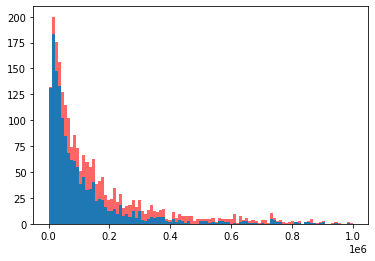

In [179]:
bins = np.linspace(0,1_000_000,100)
_,bins,_ = plt.hist(pctcf_downtss["distance"],bins=bins,alpha=0.6,color="red")
# plt.hist(xxx.drop_duplicates(subset=["chrom1_1","end1_1","end2_1"])["distance_1"],bins=bins)
plt.hist(xxx[pd.isna(xxx["start_2"])]["distance_1"],bins=bins);


In [186]:
yyy[(yyy["distance_1"]>100_000)&(yyy["strand2_1"]=="+")].rename(
    {"chrom1_1":"chrom1",
    "start1_1":"start1",
    "end1_1":"end1",
    "chrom2_1":"chrom2",
    "start2_1":"start2",
    "end2_1":"end2"},
    axis=1
    )[BEDPE_cols].astype(
    {"start1":np.int,
    "end1":np.int,
    "start2":np.int,
    "end2":np.int}
).reset_index(drop=True).to_csv("mctcf_ptss_nothingbetween.bedpe",index=False,sep="\t")



# "chrom1_1","start1_1","end1_1","type1_1","strand1_1","chrom2_1","start2_1","end2_1"
# "chrom1_1":"chrom1",
# "start1_1":"start1",
# "end1_1":"end1",
# "chrom2_1":"chrom2",
# "start2_1":"start2",
# "end2_1":"end2"